In [34]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record, get_open_orders)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
import yfinance as yf
from zipline.data import bundles

In [4]:
calendar_name = 'XNYS'
calendar = get_calendar(calendar_name)

In [6]:
bundle= 'spStocks'
bundle_data = bundles.load(bundle)

In [10]:
sids = bundle_data.asset_finder.sids
print(sids)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97)


In [66]:
ast = bundle_data.asset_finder.retrieve_all(sids)
ast[50:60]

[Equity(50 [AZO]),
 Equity(51 [BA]),
 Equity(52 [BAC]),
 Equity(53 [BALL]),
 Equity(54 [BAX]),
 Equity(55 [BBWI]),
 Equity(56 [BBY]),
 Equity(57 [BK]),
 Equity(58 [BKR]),
 Equity(59 [BMY])]

In [15]:
def RSI(df, window):
    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0  else 0)

    df['ema_gain'] = df['gain'].rolling(window).mean()
    df['ema_loss'] = df['loss'].rolling(window).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi'] = 100 - (100 / (1+ df['rs']))
    
    return df

In [63]:
capital_base = 10000
window = 30

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[50:60]

def handle_data(context, data):
    context.i += 1

    if context.i < window + 1:
        return 
    
    for asset in context.assets:
        prices = data.history(asset, ['open', 'close', 'price'], bar_count= 30, frequency = '1d' )

        rsi_value = RSI(prices, 14).rsi[-1]
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, 'price')

            if rsi_value > 70:
                order_target_percent(asset, -10, stop_price=(price*0.90))
            elif rsi_value < 30:
                order_target_percent(asset, 10, stop_price=(price * 0.90))
            else:
                order_target(asset, 0)
            
        record(closing_price = data.current(asset, 'close'),
               rsi = rsi_value)

In [64]:
start_date = pd.to_datetime('2019-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)

/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value e

/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Strategy
-------------------------  ----------
Start Period               2019-01-02
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             92.0%

Cumulative Return          45,656.17%
CAGR﹪                     731.12%

Sharpe                     0.37
Prob. Sharpe Ratio         74.33%
Smart Sharpe               0.37
Sortino                    1.18
Smart Sortino              1.18
Sortino/√2                 0.83
Smart Sortino/√2           0.83
Omega                      1.32

Max Drawdown               -557.29%
Longest DD Days            169
Volatility (ann.)          6121.46%
Calmar                     1.31
Skew                       17.35
Kurtosis                   363.32

Expected Daily %           1.22%
Expected Monthly %         29.08%
Expected Yearly %          2039.07%
Kelly Criterion            12.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -625.27%
Expected Shortfall (cVaR)  -625.27%

Max Con

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-21,2020-03-13,2020-03-17,56,-557.287321,-372.123900
2,2020-03-20,2020-04-02,2020-04-08,20,-281.246049,-279.512253
3,2020-04-13,2020-05-15,2020-05-22,40,-236.082986,-232.051011
4,2019-05-06,2019-08-15,2019-10-21,169,-208.793683,-198.009116
5,2020-06-09,2020-06-26,2020-10-07,121,-117.063162,-108.831283


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


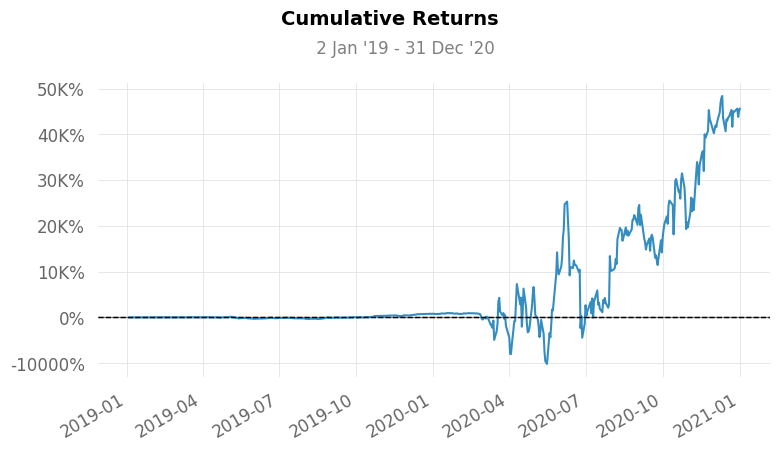

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


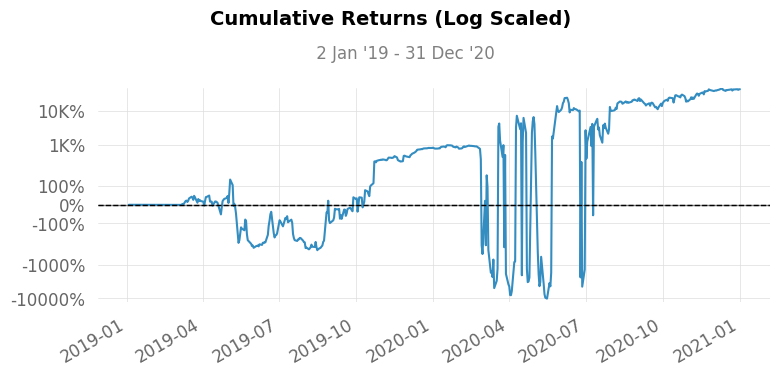

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


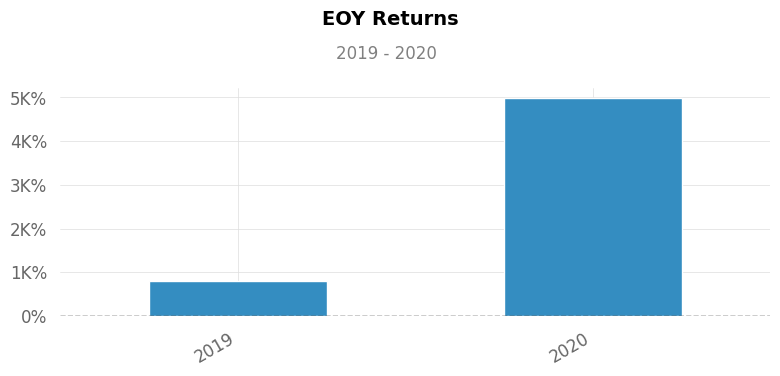

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


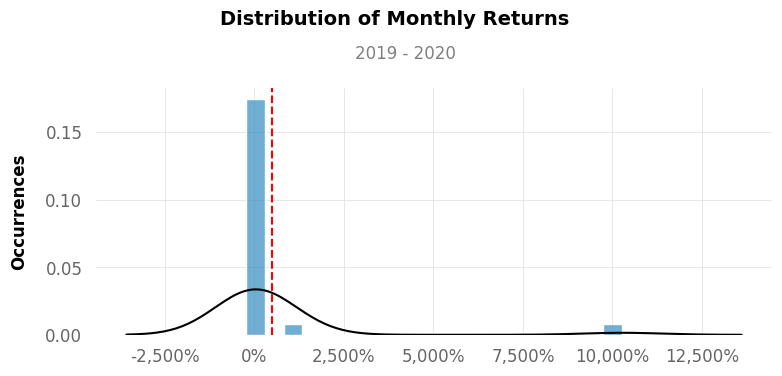

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


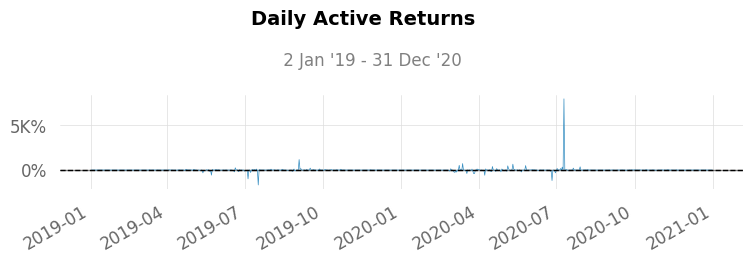

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


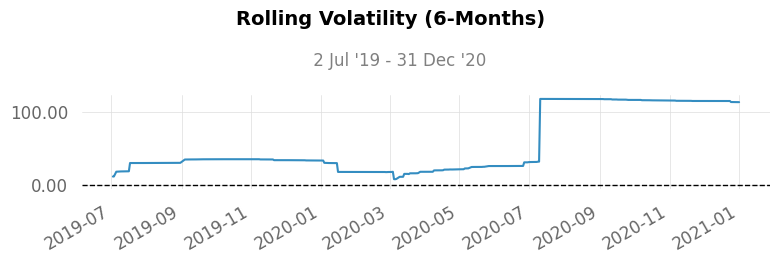

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


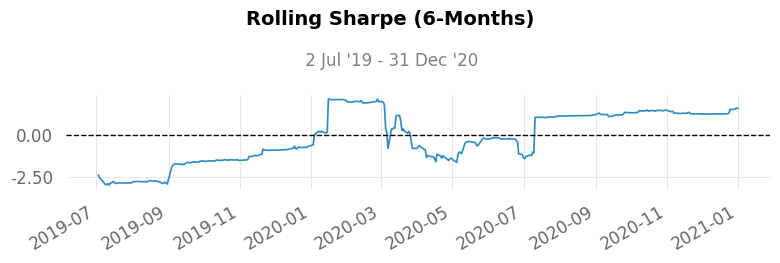

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


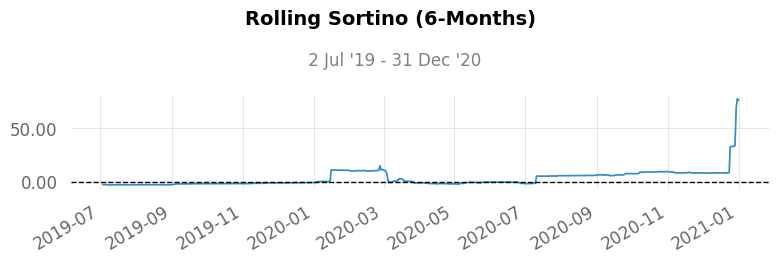

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


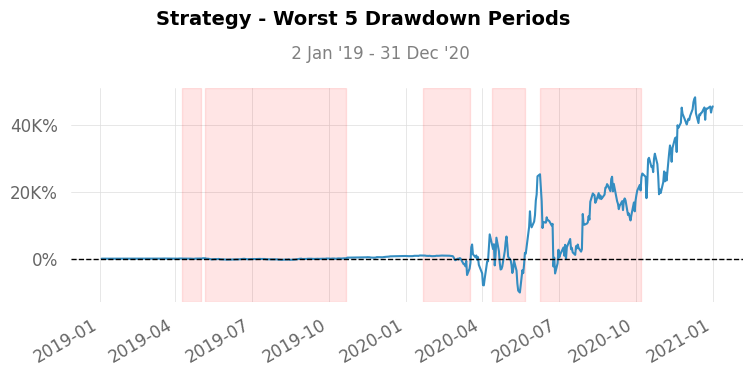

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


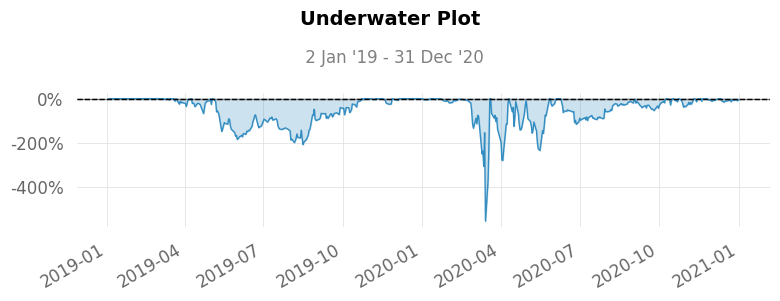

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


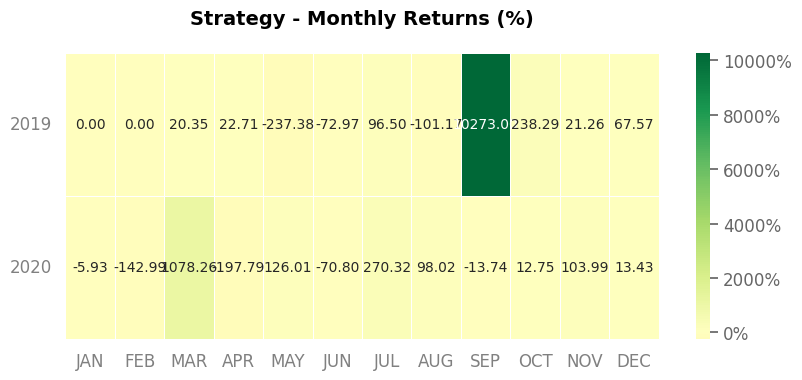

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


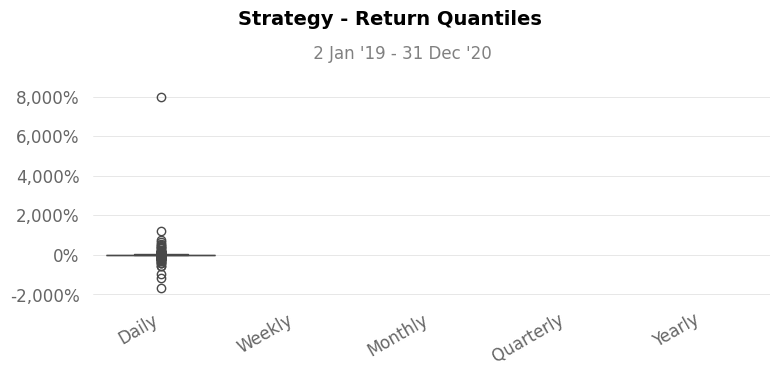

In [65]:
qs.reports.full(results.returns)